In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error


This dataset contains infrared spectra from saliva from people that tested negative and people that tested positive for SARS nCoV2019.\
The first column is the ID that contains the number of participants in this test and also the positive and negative results of the covid test.\
The second column is the Cycle threshold (Ct) that is based to get a result for being positive or negative. If this value is less so the probability of having a positive result is more.\
And other columns are the result of infrared spectra.\
As I understand every 3 rows are related to one person so we can calculate the average for every 3 rows but because the number of datasets is not so big if I do it the rows would decline to 60 and less train size of the model would raise the error of the prediction so I ignore it.
As there are many nulls in the Ct value my research is to create a model to predict the ct value.\
The best method for it would be the Linear Regression model but the important thing for using the linear regression model is having independent variables as X  matrix to can predict the dependent variable as y. so at first let's analyze the correlations
This dataset has 183 rows and 253 columns.

In [2]:
df=pd.read_excel("SourceData2.xlsx ")
df.head()

ID  Ct      1300      1298      1296      1294      1292      1290  \
0  N1 NaN  0.277705  0.277532  0.277387  0.277217  0.277042  0.276930   
1  N1 NaN  0.251624  0.251438  0.251268  0.251067  0.250843  0.250645   
2  N1 NaN  0.083310  0.083293  0.083307  0.083338  0.083391  0.083478   
3  N2 NaN  0.067509  0.067070  0.066684  0.066359  0.066106  0.065938   
4  N2 NaN  0.129576  0.128690  0.127912  0.127232  0.126676  0.126306   

       1288      1286  ...       818       816       814       812       810  \
0  0.276856  0.276737  ...  0.242726  0.241897  0.241107  0.240374  0.239742   
1  0.250467  0.250280  ...  0.213427  0.212628  0.211891  0.211234  0.210662   
2  0.083585  0.083674  ...  0.085724  0.085260  0.084823  0.084445  0.084137   
3  0.065852  0.065828  ...  0.055012  0.054969  0.054902  0.054832  0.054781   
4  0.126138  0.126113  ...  0.099128  0.098794  0.098337  0.097886  0.097527   

        808       806       804       802       800  
0  0.239234  0.238833  0.238523  0.238314  0.238197  
1  0.210173  0.209763  0.209450  0.209267  0.209202  
2  0.083894  0.083715  0.083602  0.083543  0.083495  
3  0.054767  0.054787  0.054823  0.054857  0.054893  
4  0.097272  0.097091  0.096970  0.096906  0.096881  

[5 rows x 253 columns]

shape of data

In [3]:
df.shape

(183, 253)

As we can see in the correlation heat map there are strong correlations between variables. so in these conditions, I believe the best method is Partial Least Squares regression (PLS) because it takes into account multicollinearity. we can use it for the datasets where there is a strong correlation between the regressor to predict the regressand.

<AxesSubplot:>

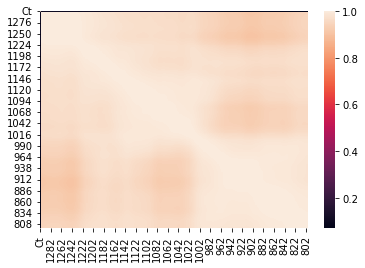

In [4]:
sns.heatmap(df.corr())

we can see 132 ct value are null out of 183

In [5]:
print(df.isnull().sum())


ID        0
Ct      132
1300      0
1298      0
1296      0
       ... 
808       0
806       0
804       0
802       0
800       0
Length: 253, dtype: int64


I dropped the null and keep the primary dataset to use after creating the model for predicting the null Ct values.

In [6]:
df_t=df.dropna()
df_t.head()

ID    Ct      1300      1298      1296      1294      1292      1290  \
90  P1  39.5  0.060928  0.060843  0.060795  0.060788  0.060815  0.060864   
91  P1  39.5  0.115645  0.115519  0.115460  0.115457  0.115491  0.115546   
92  P1  39.5  0.138667  0.138489  0.138369  0.138314  0.138327  0.138404   
93  P2  24.6  0.116097  0.115927  0.115762  0.115590  0.115403  0.115218   
94  P2  24.6  0.157963  0.157743  0.157521  0.157292  0.157054  0.156823   

        1288      1286  ...       818       816       814       812       810  \
90  0.060922  0.060978  ...  0.061845  0.061769  0.061727  0.061745  0.061819   
91  0.115618  0.115706  ...  0.113936  0.113703  0.113515  0.113385  0.113280   
92  0.138525  0.138674  ...  0.135055  0.134695  0.134373  0.134032  0.133670   
93  0.115055  0.114927  ...  0.103662  0.103419  0.103181  0.102937  0.102669   
94  0.156620  0.156446  ...  0.142669  0.142337  0.142044  0.141792  0.141571   

         808       806       804       802       800  
90  0.061908  0.061968  0.061993  0.062016  0.062058  
91  0.113164  0.113053  0.112994  0.112999  0.113014  
92  0.133365  0.133188  0.133120  0.133073  0.132981  
93  0.102376  0.102082  0.101817  0.101597  0.101429  
94  0.141358  0.141141  0.140930  0.140746  0.140600  

[5 rows x 253 columns]

check the type of columns

In [7]:
df_t.dtypes

ID       object
Ct      float64
1300    float64
1298    float64
1296    float64
         ...   
808     float64
806     float64
804     float64
802     float64
800     float64
Length: 253, dtype: object

we can see the variance of columns is in the same range so there is no need to standardize.

In [8]:
df_t.describe()

Ct       1300       1298       1296       1294       1292  \
count  51.000000  51.000000  51.000000  51.000000  51.000000  51.000000   
mean   29.997059   0.290714   0.290137   0.289621   0.289177   0.288844   
std     6.331812   0.204720   0.204411   0.204134   0.203922   0.203811   
min    16.950000   0.060928   0.060843   0.060795   0.060788   0.060815   
25%    27.150000   0.138679   0.138573   0.138498   0.138446   0.138437   
50%    30.000000   0.221922   0.221259   0.220595   0.220091   0.219777   
75%    33.350000   0.367465   0.366739   0.366194   0.365803   0.365537   
max    39.900000   0.818293   0.817143   0.815908   0.814782   0.813889   

            1290       1288       1286       1284  ...        818        816  \
count  51.000000  51.000000  51.000000  51.000000  ...  51.000000  51.000000   
mean    0.288680   0.288686   0.288800   0.288968  ...   0.215964   0.215743   
std     0.203854   0.204074   0.204419   0.204796  ...   0.143464   0.143555   
min     0.060864   0.060922   0.060978   0.061034  ...   0.040589   0.040850   
25%     0.138486   0.138561   0.138643   0.138762  ...   0.103825   0.103696   
50%     0.219672   0.219679   0.219659   0.219606  ...   0.170616   0.170046   
75%     0.365417   0.365438   0.365547   0.365720  ...   0.328995   0.329668   
max     0.813383   0.813412   0.813906   0.814597  ...   0.537173   0.539202   

             814        812        810        808        806        804  \
count  51.000000  51.000000  51.000000  51.000000  51.000000  51.000000   
mean    0.215508   0.215262   0.215020   0.214788   0.214559   0.214340   
std     0.143662   0.143764   0.143838   0.143870   0.143866   0.143850   
min     0.040923   0.040839   0.040731   0.040705   0.040742   0.040737   
25%     0.103572   0.103420   0.103247   0.103069   0.102891   0.102716   
50%     0.169460   0.168897   0.168398   0.167950   0.167497   0.167039   
75%     0.330264   0.330179   0.329707   0.329291   0.328952   0.328716   
max     0.541285   0.543282   0.545053   0.546491   0.547551   0.548283   

             802        800  
count  51.000000  51.000000  
mean    0.214166   0.214062  
std     0.143858   0.143934  
min     0.040618   0.040387  
25%     0.102555   0.102411  
50%     0.166648   0.166357  
75%     0.328634   0.328750  
max     0.548874   0.549605  

[8 rows x 252 columns]

split the dataset to X and y

In [9]:
X=df_t.iloc[:,2:]
y=df_t.iloc[:,1]

for the best component, it is better to use k_fold cross-validation to find the optimal number of PLS components to keep in the model but I do not have enough time so I tested with 5,6, and 7 and I think 6 is the best. I believe that the size of the dataset is so small so if we have more samples we can split the data to test and train to get a lower error and better prediction.

In [10]:
model=PLSRegression(n_components=6)
model.fit(X, y)

PLSRegression(n_components=6)

predict the values

predict the y and calculate the error. As we can see the error is not good, it shows that other factors also affect the Ct values, so for the next step is better to add other factors to predict the Ct value or increase the size of samples to train the model with more train samples.

In [11]:
y_pred = model.predict(X)
np.sqrt(mean_squared_error(y, y_pred))

5.50549218531295

predict the Ct value for the primary dataset and add new columns in the dataset.we can see a very good plot, so I think if we increase the train size we will get a very low error.

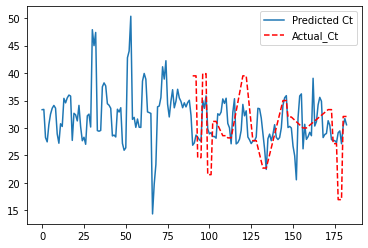

In [12]:
df["predicted_Ct"] = model.predict(df.iloc[:,2:])
plt.plot(df["predicted_Ct"],label="Predicted Ct")
plt.plot(y,'r--',label="Actual_Ct")
plt.legend()
plt.show()